<a href="https://colab.research.google.com/github/jgbrenner/psychometrics/blob/main/C9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Generating Psychometric Scale Items Using an Open Source LLM and Conducting Exploratory Graph Analysis**



# Methodology

# Overview

In this notebook, I will utilize an open-source large language model (LLM) to generate items for a psychometric scale measuring three dimensions of perfectionism: Rigid Perfectionism, Self-Critical Perfectionism, and Narcissistic Perfectionism. Following item generation, I will perform Exploratory Graph Analysis (EGA) to validate the structure and dimensionality of the generated items.


# Steps Involved

Item Generation:
I prompted the LLM to generate six items for each construct, specifying that five should be regular-keyed and one should be reverse-keyed. The output was formatted in JSON for easy processing.
The constructs targeted are:

- Rigid Perfectionism

- Self-Critical Perfectionism

- Narcissistic Perfectionism


# Data Preparation:

The generated items were compiled into a data frame, and constructs were extracted for further analysis.
An embeddings array was created to represent the items in a high-dimensional space suitable for EGA.

# Transfer to R:

The embeddings array and constructs list were transferred from Python to R using the rpy2 interface.

# Exploratory Graph Analysis (EGA):

In R, the embeddings array was converted into a matrix format, with appropriate row names assigned based on the constructs.
The EGAnet library was utilized to perform EGA on the embeddings matrix, allowing for an exploration of the underlying structure of the psychometric items.

Results were printed and visualized to assess the dimensionality of the constructs.

# Conclusion
This methodology enables a systematic approach to generating and validating psychometric scale items, ensuring that they are both relevant and statistically sound.

In [2]:
!pip install groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 2.2 MB/s eta 0:00:00


In [3]:
# Load the R magic extension for rpy2
%load_ext rpy2.ipython

import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define the path where the R library will be saved in Google Drive
library_path = '/content/drive/MyDrive/R_libraries'

# Create the directory if it doesn't exist
if not os.path.exists(library_path):
    os.makedirs(library_path)

Mounted at /content/drive


In [4]:
#verify rpy2 version as this is known to cause errors ( ver 3.4.2 works fine )
import rpy2
print(f"rpy2 version: {rpy2.__version__}")

rpy2 version: 3.4.2


In [5]:
%%R -i library_path

# Set the custom library path to persist during the Colab session
.libPaths(library_path)

# Set CRAN repository globally
options(repos = c(CRAN = "https://cloud.r-project.org"))

# List of required R packages
required_packages <- c("gmp", "Rmpfr", "CVXR", "fungible", "EGAnet")

# Install each package only if it's not already installed
for (pkg in required_packages) {
    if (!requireNamespace(pkg, quietly = TRUE)) {
        install.packages(pkg, lib = library_path, dependencies = TRUE)
    }
}

# Load EGAnet library
library(EGAnet)


EGAnet (version 2.1.0) 

For help getting started, see <https://r-ega.net> 

For bugs and errors, submit an issue to <https://github.com/hfgolino/EGAnet/issues>



In [6]:
# Import necessary Python libraries
import openai
import pandas as pd
import numpy as np
import json
import requests
import re


from google.colab import userdata

#fetching the OpenAI API key from secrets
openai_api_key = userdata.get('OPENAI_API_KEY')

from groq import Groq

#fetching the Groq API key from secrets
groq_api_key = userdata.get('GROQ_API_KEY')

# Initialize the Groq client
client = Groq(api_key=groq_api_key)

# Prompting is everything.

 Using the llama3-8b-8192 model  with this particualr prompt I was able to get the results needed. For other models the prompt might need to be modified, as all models are non-deterministic.

In [7]:
# Define the messages for the LLM
messages = [
    {
        "role": "system",
        "content": "You are an expert psychometrician creating test items."
    },
    {
        "role": "user",
        "content": (
            "Please generate six items for each of the following constructs: "
            "Rigid Perfectionism, Self-Critical Perfectionism, and Narcissistic Perfectionism. "
            "For each construct, provide five regular-keyed and one reverse-keyed item. "
            "Make them concise and clear. "
            "Provide the output ONLY in JSON format as a list of dictionaries, "
            "without any additional text or explanation. "
            "Each dictionary should have keys 'construct', 'item', and 'type' (either 'regular-keyed' or 'reverse-keyed')."
        )
    }
]

try:
    # Create the completion request
    completion = client.chat.completions.create(
        model="llama3-8b-8192", # using opensource model for replication purposes
        messages=messages,
        temperature=1,
        max_tokens=2048,
        top_p=1,
        stream=False,  # Disable streaming for simplicity
        stop=None,
    )

    # Collect the response content
    response_content = completion.choices[0].message.content
    print("\nLLM Output:\n", response_content)

except Exception as e:
    print(f"An error occurred: {e}")
    response_content = ""



LLM Output:
 [
    {
        "construct": "Rigid Perfectionism",
        "item": "I set extremely high standards for my performance.",
        "type": "regular-keyed"
    },
    {
        "construct": "Rigid Perfectionism",
        "item": "I tolerate very little variability in my work.",
        "type": "regular-keyed"
    },
    {
        "construct": "Rigid Perfectionism",
        "item": "I expect myself to achieve perfection in everything I do.",
        "type": "regular-keyed"
    },
    {
        "construct": "Rigid Perfectionism",
        "item": "Other people don't understand my dedication to excellence.",
        "type": "regular-keyed"
    },
    {
        "construct": "Rigid Perfectionism",
        "item": "I spend a lot of time revising and editing to ensure perfection.",
        "type": "regular-keyed"
    },
    {
        "construct": "Rigid Perfectionism",
        "item": "With less strict standards, I'd be more careless in my work.",
        "type": "reverse-keyed"
  

In [29]:
# Parse the JSON response
try:
    generated_items = json.loads(response_content)
    items_df = pd.DataFrame(generated_items)
except json.JSONDecodeError as e:
    print(f"JSON decoding failed: {e}")
    # Attempt to extract JSON content from the response
    json_match = re.search(r'\[.*\]', response_content, re.DOTALL)
    if json_match:
        json_str = json_match.group(0)
        try:
            generated_items = json.loads(json_str)
            items_df = pd.DataFrame(generated_items)
        except json.JSONDecodeError as e2:
            print(f"Second JSON decoding attempt failed: {e2}")
            items_df = None
    else:
        print("No JSON content found in the response.")
        items_df = None

# Check if items_df is defined
if items_df is not None:
    # Save to CSV (optional)
    items_df.to_csv("perfectionism_items.csv", index=False)
    print("Items saved to 'perfectionism_items.csv'.")

    # Prepare the list of items
    item_texts = items_df["item"].tolist()

    # Ensure item_texts is clean and valid
    item_texts = [item for item in item_texts if item.strip()]  # Filter empty strings

    # Set up the API endpoint and headers for OpenAI embeddings
    embedding_endpoint = "https://api.openai.com/v1/embeddings"
    embedding_model = "text-embedding-3-small"  # Using a commonly available model

    headers = {
        "Authorization": f"Bearer {openai_api_key}",
        "Content-Type": "application/json"
    }

    # Prepare the data payload
    data = {
        "model": embedding_model,
        "input": item_texts
    }

    # Make the API request
    try:
        response = requests.post(embedding_endpoint, headers=headers, json=data)

        # Check if the request was successful
        if response.status_code != 200:
            print(f"Request failed with status code {response.status_code}: {response.text}")
        else:
            response_data = response.json()
            # Extract embeddings
            embeddings = [item['embedding'] for item in response_data['data']]
            embeddings_array = np.array(embeddings)
            print(f"Embeddings generated successfully. Shape: {embeddings_array.shape}")
            # Save the embeddings
            np.save("embeddings.npy", embeddings_array)
            print("Embeddings saved as 'embeddings.npy'.")
    except Exception as e:
        print(f"An error occurred during embedding generation: {e}")
else:
    print("Error: items_df is not defined. Cannot proceed with embedding generation.")



Items saved to 'perfectionism_items.csv'.
Embeddings generated successfully. Shape: (18, 1536)
Embeddings saved as 'embeddings.npy'.


In [30]:
# Prepare constructs list with unique item labels
items_df['item_label'] = items_df.apply(lambda row: f"{row['construct']}_{row.name+1}", axis=1)
items_constructs = items_df['item_label'].tolist()

# Transfer data to R
%R -i embeddings_array -i items_constructs

In [41]:
%%R
# Convert embeddings_array to a matrix
embeddings_matrix <- as.matrix(embeddings_array)

# Assign unique row names to the matrix
rownames(embeddings_matrix) <- items_constructs

# Compute the correlation matrix between items
cor_matrix <- cor(t(embeddings_matrix))

# Load EGAnet library
library(EGAnet)

# Perform EGA analysis with adjusted parameters
ega_result <- EGA(
    data = cor_matrix,
    n = nrow(cor_matrix),
    #corr = NULL,          # Indicate that data is a correlation matrix
    model = "glasso",
    args.glasso = list(gamma = 0.25),  # Adjust gamma to reduce regularization
    plot.EGA = TRUE,
    verbose = TRUE
)

# Print the EGA results
print(ega_result)

# Plot the results
plot(ega_result)


Model: GLASSO (EBIC with gamma = 0)
Correlations: auto
Lambda: 0.77921682944779 (n = 100, ratio = 0.1)

Number of nodes: 18
Number of edges: 0
Edge density: 0.000

Non-zero edge weights: 
     M    SD   Min   Max
 0.000 0.000 0.000 0.000

----

Algorithm:  Walktrap

Number of communities:  0

         Rigid Perfectionism_1          Rigid Perfectionism_2 
                            NA                             NA 
         Rigid Perfectionism_3          Rigid Perfectionism_4 
                            NA                             NA 
         Rigid Perfectionism_5          Rigid Perfectionism_6 
                            NA                             NA 
 Self-Critical Perfectionism_7  Self-Critical Perfectionism_8 
                            NA                             NA 
 Self-Critical Perfectionism_9 Self-Critical Perfectionism_10 
                            NA                             NA 
Self-Critical Perfectionism_11 Self-Critical Perfectionism_12 
             

NULL


In [35]:
%%R
print(cor_matrix)

                               Rigid Perfectionism_1 Rigid Perfectionism_2
Rigid Perfectionism_1                      1.0000000             0.4273928
Rigid Perfectionism_2                      0.4273928             1.0000000
Rigid Perfectionism_3                      0.5817057             0.3790249
Rigid Perfectionism_4                      0.4874238             0.3432726
Rigid Perfectionism_5                      0.4323360             0.3200593
Rigid Perfectionism_6                      0.4665854             0.4579145
Self-Critical Perfectionism_7              0.5431090             0.3404875
Self-Critical Perfectionism_8              0.5849187             0.2916860
Self-Critical Perfectionism_9              0.3622883             0.3221480
Self-Critical Perfectionism_10             0.3341045             0.2694316
Self-Critical Perfectionism_11             0.3002475             0.3016687
Self-Critical Perfectionism_12             0.4015899             0.3861447
Narcissistic Perfectionis

In [37]:
%%R

# Summary statistics of the correlation matrix
summary(cor_matrix)

 Rigid Perfectionism_1 Rigid Perfectionism_2 Rigid Perfectionism_3
 Min.   :0.3002        Min.   :0.1875        Min.   :0.3274       
 1st Qu.:0.3723        1st Qu.:0.2750        1st Qu.:0.3734       
 Median :0.4290        Median :0.3109        Median :0.4319       
 Mean   :0.4647        Mean   :0.3522        Mean   :0.4598       
 3rd Qu.:0.4932        3rd Qu.:0.3701        3rd Qu.:0.4484       
 Max.   :1.0000        Max.   :1.0000        Max.   :1.0000       
 Rigid Perfectionism_4 Rigid Perfectionism_5 Rigid Perfectionism_6
 Min.   :0.2713        Min.   :0.1819        Min.   :0.1908       
 1st Qu.:0.3180        1st Qu.:0.2787        1st Qu.:0.2892       
 Median :0.3941        Median :0.3319        Median :0.3266       
 Mean   :0.4173        Mean   :0.3661        Mean   :0.3817       
 3rd Qu.:0.4451        3rd Qu.:0.4148        3rd Qu.:0.4376       
 Max.   :1.0000        Max.   :1.0000        Max.   :1.0000       
 Self-Critical Perfectionism_7 Self-Critical Perfectionism_8
 

In [42]:
%%R

pca_result <- prcomp(cor_matrix, scale. = TRUE)
summary(pca_result)


Importance of components:
                          PC1    PC2    PC3     PC4     PC5     PC6     PC7
Standard deviation     2.4820 1.6132 1.4521 1.23172 1.01310 0.93866 0.82987
Proportion of Variance 0.3422 0.1446 0.1172 0.08429 0.05702 0.04895 0.03826
Cumulative Proportion  0.3422 0.4868 0.6040 0.68827 0.74529 0.79424 0.83250
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     0.80595 0.73535 0.67325 0.65384 0.51491 0.49819 0.40338
Proportion of Variance 0.03609 0.03004 0.02518 0.02375 0.01473 0.01379 0.00904
Cumulative Proportion  0.86859 0.89863 0.92381 0.94756 0.96229 0.97608 0.98512
                          PC15    PC16    PC17      PC18
Standard deviation     0.36540 0.31158 0.19313 7.726e-17
Proportion of Variance 0.00742 0.00539 0.00207 0.000e+00
Cumulative Proportion  0.99253 0.99793 1.00000 1.000e+00


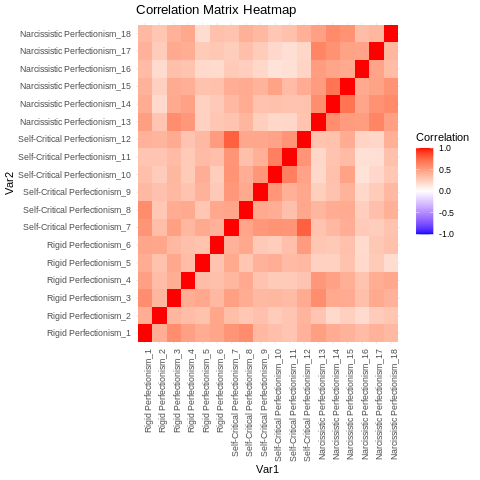

In [38]:
%%R

library(ggplot2)
library(reshape2)

# Melt the correlation matrix for plotting
heatmap_data <- melt(cor_matrix)

# Create a heatmap
ggplot(heatmap_data, aes(Var1, Var2, fill = value)) +
    geom_tile() +
    scale_fill_gradient2(low = "blue", high = "red", mid = "white", limit = c(-1, 1), name="Correlation") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    labs(title = "Correlation Matrix Heatmap")

In [40]:
%%R

high_correlations <- which(abs(cor_matrix) > 0.5 & lower.tri(cor_matrix), arr.ind = TRUE)
high_correlations_df <- as.data.frame(high_correlations)

# Display item pairs with high correlations
print(high_correlations_df)

                                 row col
Rigid.Perfectionism_3              3   1
Self.Critical.Perfectionism_7      7   1
Self.Critical.Perfectionism_8      8   1
Narcissistic.Perfectionism_13     13   3
Narcissistic.Perfectionism_13.1   13   4
Self.Critical.Perfectionism_12    12   6
Self.Critical.Perfectionism_9      9   7
Self.Critical.Perfectionism_10    10   7
Self.Critical.Perfectionism_11    11   7
Self.Critical.Perfectionism_12.1  12   7
Self.Critical.Perfectionism_10.1  10   9
Self.Critical.Perfectionism_11.1  11  10
Self.Critical.Perfectionism_12.2  12  11
Narcissistic.Perfectionism_14     14  13
Narcissistic.Perfectionism_15     15  13
Narcissistic.Perfectionism_16     16  13
Narcissistic.Perfectionism_17     17  13
Narcissistic.Perfectionism_15.1   15  14
Narcissistic.Perfectionism_17.1   17  14
Narcissistic.Perfectionism_18     18  14
Narcissistic.Perfectionism_18.1   18  15


Model: GLASSO (EBIC with gamma = 0.5)
Correlations: auto
Lambda: 0.0761302601265623 (n = 100, ratio = 0.01)

Number of nodes: 18
Number of edges: 83
Edge density: 0.542

Non-zero edge weights: 
     M    SD   Min   Max
 0.095 0.093 0.002 0.506

----

Algorithm:  Walktrap

Number of communities:  3

         Rigid Perfectionism_1          Rigid Perfectionism_2 
                             1                              1 
         Rigid Perfectionism_3          Rigid Perfectionism_4 
                             2                              2 
         Rigid Perfectionism_5          Rigid Perfectionism_6 
                             3                              1 
 Self-Critical Perfectionism_7  Self-Critical Perfectionism_8 
                             3                              1 
 Self-Critical Perfectionism_9 Self-Critical Perfectionism_10 
                             3                              3 
Self-Critical Perfectionism_11 Self-Critical Perfectionism_12 
       

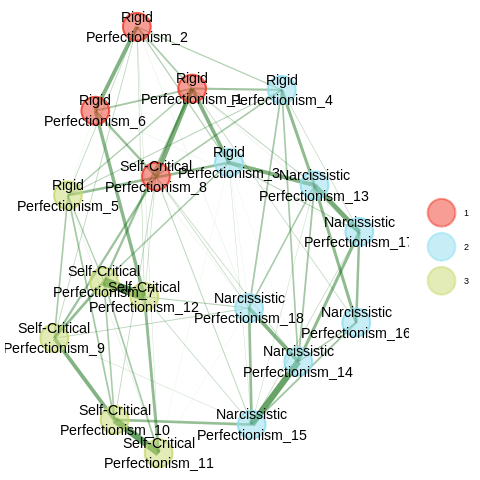

In [45]:
%%R
# Convert embeddings_array to a matrix
embeddings_matrix <- as.matrix(embeddings_array)

# Assign row names to the matrix
rownames(embeddings_matrix) <- items_constructs

# Compute the correlation matrix between items
cor_matrix <- cor(t(embeddings_matrix))

# Load EGAnet library
library(EGAnet)

# Perform EGA analysis with adjusted parameters
ega_result <- EGA(
    data = cor_matrix,
    n = 100,                # Set a hypothetical sample size
    corr = "auto",           # Indicate that data is a correlation matrix
    model = "glasso",
    lambda.min.ratio = 0.01,    # Reduce lambda.min.ratio
    args.glasso = list(gamma = 0),  # Reduce gamma for sensitivity
    plot.EGA = TRUE,
    verbose = TRUE
)

# Print the results
print(ega_result)

